## Training loop for multi class classification

### Data generation

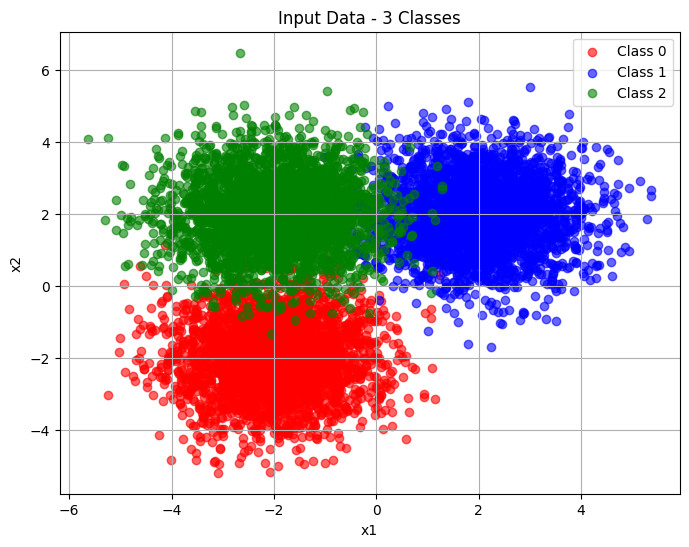

In [6]:
# Data Generation and Visualization
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 1. Generate 2D Gaussian data with 3 clusters
np.random.seed(42)
n_samples_per_class = 3000
n_classes = 3
n_features = 2

# Generate data for each cluster
X = []
y = []
means = [[-2, -2], [2, 2], [-2, 2]]
for i in range(n_classes):
    X_i = np.random.randn(n_samples_per_class, n_features) + means[i]
    X.append(X_i)
    y.append(np.full(n_samples_per_class, i))

# Stack and reshape X to be [n_features, n_samples]
X = np.vstack(X)          # Shape: [n_samples, n_features]
X = X.T                   # Shape: [n_features, n_samples]
y = np.hstack(y)          # Shape: [n_samples]

# Convert to one-hot encoding [n_classes, n_samples]
y_onehot = np.zeros((n_classes, len(y)))
y_onehot[y, np.arange(len(y))] = 1

# Visualization of input data
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(n_classes):
    mask = y == i
    plt.scatter(X[0,mask], X[1,mask], color=colors[i], label=f'Class {i}', alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Input Data - 3 Classes")
plt.grid(True)
plt.show()


### Training

### Using derived gradients

In [7]:

# Training setup
np.random.seed(42)
W_init = np.random.randn(n_classes, n_features) * 0.01  # Shape: [3, 2]
b_init = np.zeros((n_classes, 1))                       # Shape: [3, 1]
lr = 0.1
epochs = 1000

# NumPy implementation
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def forward(W, b, X):
    # W: [3, 2], X: [2, n_samples] -> z: [3, n_samples]
    z = W @ X + b
    return softmax(z)

def cross_entropy_loss(probs, y_true):
    return -np.mean(np.sum(y_true * np.log(probs + 1e-10), axis=0))

def compute_gradients(X, probs, y_true):
    m = X.shape[1]  # number of examples
    dz = probs - y_true  # [3, n_samples]
    dW = (dz @ X.T) / m  # [3, n_samples] @ [2, n_samples].T -> [3, 2]
    db = np.mean(dz, axis=1, keepdims=True)  # [3, 1]
    return dW, db

# NumPy training loop
W_np = W_init.copy()
b_np = b_init.copy()
loss_np = []

for epoch in range(epochs):
    probs = forward(W_np, b_np, X)
    loss = cross_entropy_loss(probs, y_onehot)
    dW, db = compute_gradients(X, probs, y_onehot)
    W_np -= lr * dW
    b_np -= lr * db
    loss_np.append(loss)


### Using PyTorch

In [8]:

# PyTorch implementation
X_torch = torch.tensor(X, dtype=torch.float32)  # [2, n_samples]
y_torch = torch.tensor(y, dtype=torch.long)     # [n_samples]

W_torch = torch.tensor(W_init, dtype=torch.float32, requires_grad=True)  # [3, 2]
b_torch = torch.tensor(b_init, dtype=torch.float32, requires_grad=True)  # [3, 1]
loss_torch = []

# Define loss criterion once
cross_entropy_loss = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    z = W_torch @ X_torch + b_torch  # [3, n_samples]
    # CrossEntropyLoss expects input of shape [n_samples, n_classes]
    loss = cross_entropy_loss(z.T, y_torch)
    loss_torch.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        W_torch -= lr * W_torch.grad
        b_torch -= lr * b_torch.grad
    
    W_torch.grad.zero_()
    b_torch.grad.zero_()


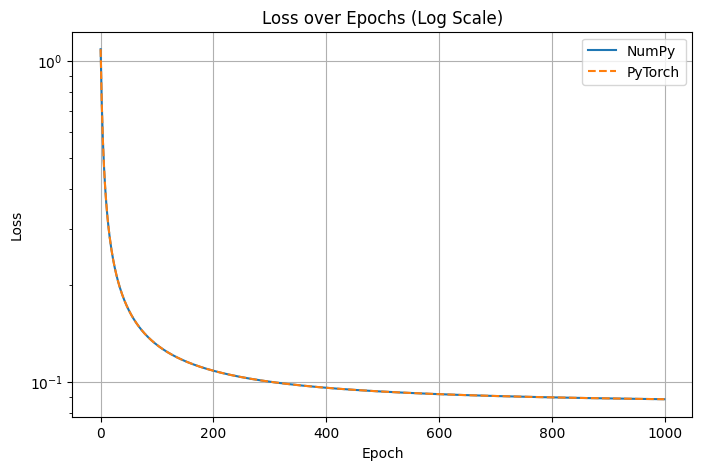

In [9]:

# Plot training loss
plt.figure(figsize=(8, 5))
plt.semilogy(loss_np, label='NumPy')
plt.semilogy(loss_torch, label='PyTorch', linestyle='--')
plt.title("Loss over Epochs (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


### Classification Results with decision boundaries

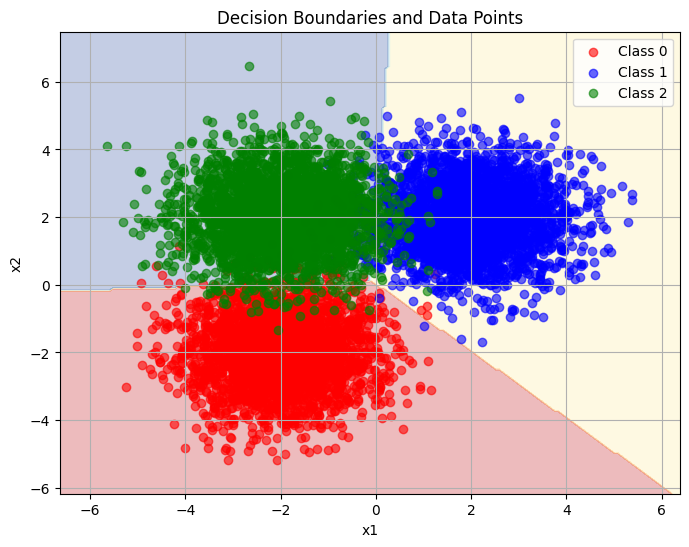

In [10]:

# Plot decision boundaries
x_min, x_max = X[0].min() - 1, X[0].max() + 1
y_min, y_max = X[1].min() - 1, X[1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
X_grid = np.c_[xx.ravel(), yy.ravel()].T  # Shape: [2, n_points]

# Get predictions
probs = forward(W_np, b_np, X_grid)        # Shape: [3, n_points]
predictions = np.argmax(probs, axis=0)     # Shape: [n_points]

# Plot decision boundaries and points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, predictions.reshape(xx.shape), alpha=0.3, cmap='RdYlBu')
for i in range(n_classes):
    mask = y == i
    plt.scatter(X[0,mask], X[1,mask], color=colors[i], label=f'Class {i}', alpha=0.6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.title("Decision Boundaries and Data Points")
plt.grid(True)
plt.show()